#### Aim
_classify texts written by students into three categories: efective, adequate, ineffective_ <br>
_eval method: multi class log loss_

In [85]:
import pandas as pd
import numpy as np
import re

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
sns.set_palette('Spectral_r')

In [87]:
RANDOM_SEED = 22

#### Initial steps 
Remarks:
- _'discourse effectiveness' is the target variable_ 
    - somewhat unbalanced
        - adequate: .57
        - effective: .25
        - ineffective: .17
<br>
<br>
- _'discourse_id' unique for each entry_

- _'essay_id' denotes the context; text can be loaded in the for more inherent information_
    - _seems to be normally distributed, each essay appearing ~ 10x_
<br>
<br>
- _'discourse_type' is a catgorical feature with 7 unique categories: 
    - _'Rebuttal', 'Counterclaim', 'Lead', 'Concluding Statement', 'Position',
       'Claim', 'Evidence'_
    - Frequency: 
        'Rebuttal': 0.03383653, 
        'Counterclaim': 0.04822521, 
        'Lead': 0.0623147 , 
        'Concluding Statement': 0.09114647, 
        'Position': 0.10945192,
        __'Claim' : 0.32577179__, 
        __'Evidence': 0.32925337__

<br>
<br>
- TODO: _'discourse_text'_
<br>
- TODO: _'essay_text'_


<br>
<br>

- Questions to think about: 
    - What makes an argument effective? And, conversely one ineffective?
    - Does the degree of formalness matter? What kind of language is used?
    - Is it relatedness to the topic at hand?
    
    - Why does _discourse type_ matter?
         

worth checking out: ECDF of syll_per_words for each target label <br>
is it significant?
not sure

####  Data reading, info, describe


In [88]:
train_path = "train.csv"
test_path =  "test.csv"

In [89]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train['essay_text'] = train['essay_id'].apply(lambda x: open(f"train/{x}.txt", encoding='utf-8').read())
test['essay_text'] = test['essay_id'].apply(lambda x: open(f"test/{x}.txt", encoding='utf-8').read())

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
 5   essay_text               36765 non-null  object
dtypes: object(6)
memory usage: 1.7+ MB


In [91]:
train.describe().T

,count,unique,top,freq
discourse_id,36765,36765,0013cc385424,1
essay_id,36765,4191,91B1F82B2CF1,23
discourse_text,36765,36691,Summer projects should be student-designed,14
discourse_type,36765,7,Evidence,12105
discourse_effectiveness,36765,3,Adequate,20977
essay_text,36765,4191,Many people may think that attending school on...,23


In [92]:
test.describe().T

,count,unique,top,freq
discourse_id,10,10,a261b6e14276,1
essay_id,10,1,D72CB1C11673,10
discourse_text,10,10,Making choices in life can be very difficult. ...,1
discourse_type,10,5,Claim,4
essay_text,10,1,Making choices in life can be very difficult. ...,10


In [93]:
train.head(25)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective,"Hi, i'm Isaac, i'm going to be writing about h..."
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,Limiting the usage of cars has personal and pr...


In [94]:
train.discourse_text

0        Hi, i'm Isaac, i'm going to be writing about h...
1        On my perspective, I think that the face is a ...
2        I think that the face is a natural landform be...
3        If life was on Mars, we would know by now. The...
4        People thought that the face was formed by ali...
                               ...                        
36760    For many people they don't like only asking on...
36761    also people have different views and opinions ...
36762    Advice is something that can impact a persons ...
36763    someone can use everything that many people sa...
36764    In conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 36765, dtype: object

#### Essay_id

In [95]:
subset = train.essay_id.value_counts()
subset

91B1F82B2CF1    23
4CA37D113612    23
900A879708F0    23
A7EC6F462F8B    22
DECAE402BB38    22
                ..
AB02689C1A9B     1
FFFF80B8CC2F     1
377548575048     1
5E85F1FB4E22     1
9706F8E7D534     1
Name: essay_id, Length: 4191, dtype: int64

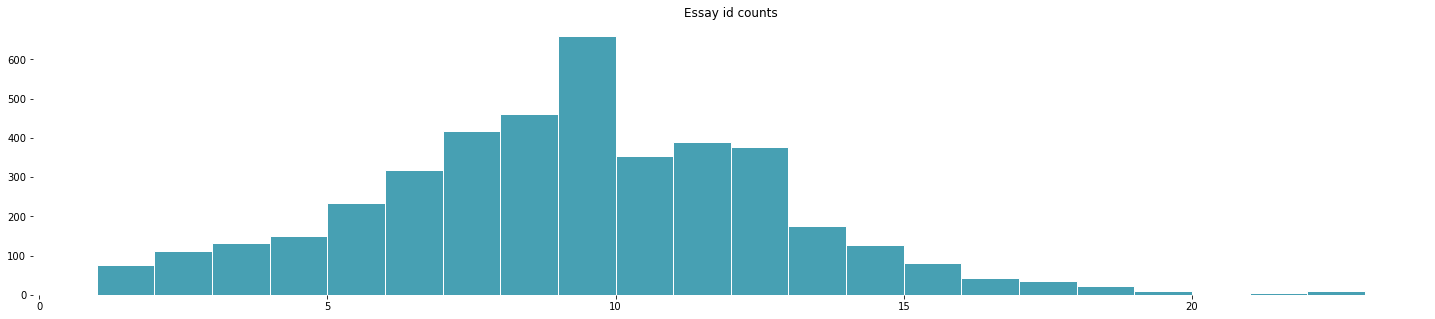

In [96]:
plt.figure(figsize = (25,5))
plt.hist(subset.values, rwidth = 1, bins = 22, align='mid', edgecolor = 'white')
plt.title('Essay id counts')
plt.box(False)
plt.show()

The majority of essays appear ~10 times.


#### Discourse effectiveness

In [97]:
subset = train.discourse_effectiveness.value_counts(ascending=True)
subset = subset / len(train)

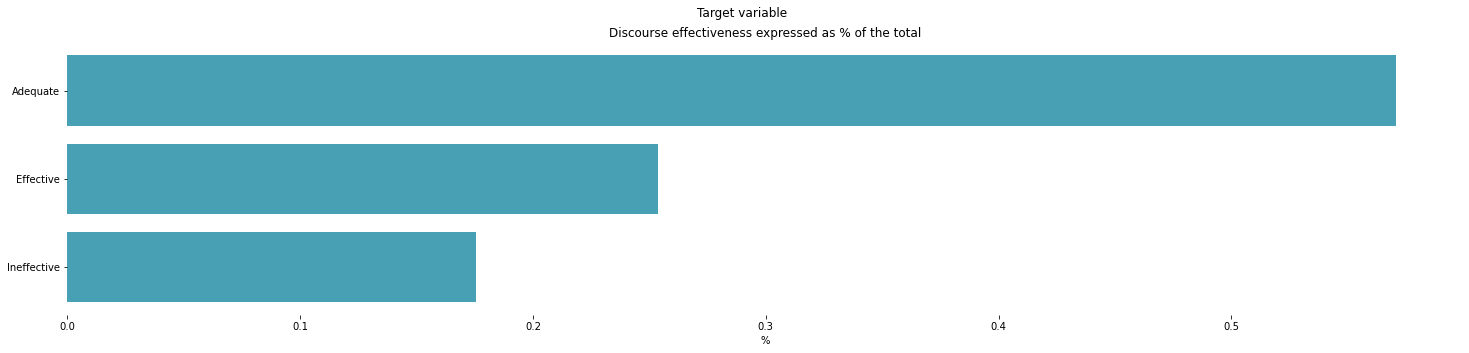

In [98]:
plt.figure(figsize = (25,5))
plt.barh(y = subset.index, width=subset.values)
plt.title('Discourse effectiveness expressed as % of the total')
plt.suptitle('Target variable')
plt.xlabel('%')
plt.box(False)
plt.show()

In [99]:
subset.values

array([0.17576499, 0.25366517, 0.57056984])

So it it somewhat unbalanced.

In [100]:
len(train) - train.discourse_text.nunique() 

74

There are 74 instances where one or more _discourse_texts_ is repeated.

#### Discourse_text 

In [101]:
subset = train.discourse_type.value_counts(ascending=True)
subset = subset / len(train)

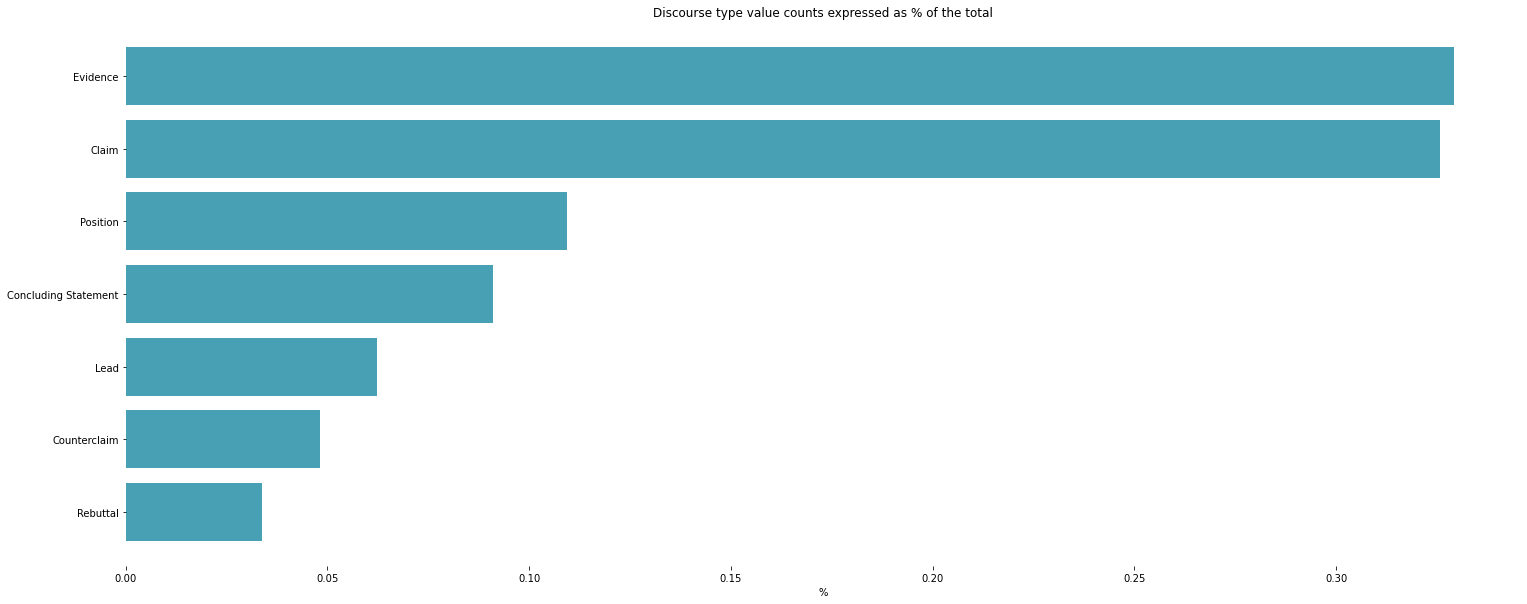

In [102]:
plt.figure(figsize = (25,10))
plt.barh(y = subset.index, width=subset.values)
plt.title('Discourse type value counts expressed as % of the total')
plt.xlabel('%')
plt.box(False)
plt.show()

In [103]:
subset.values

array([0.03383653, 0.04822521, 0.0623147 , 0.09114647, 0.10945192,
       0.32577179, 0.32925337])

In [104]:
subset = train.loc[train.discourse_effectiveness == 'Adequate'].discourse_type
subset = sorted(subset)

In [105]:
plt.figure(figsize = (25,10))
sns.histplot(subset, edgecolor = 'white')
plt.box(False)Isi

SyntaxError: invalid syntax (3874334604.py, line 3)

In [ ]:
subset = train.discourse_text.str.len()
subset

0        317
1        210
2        105
3        362
4        101
        ... 
36760    126
36761     57
36762    121
36763    439
36764     67
Name: discourse_text, Length: 36765, dtype: int64

#### Discourse text 2

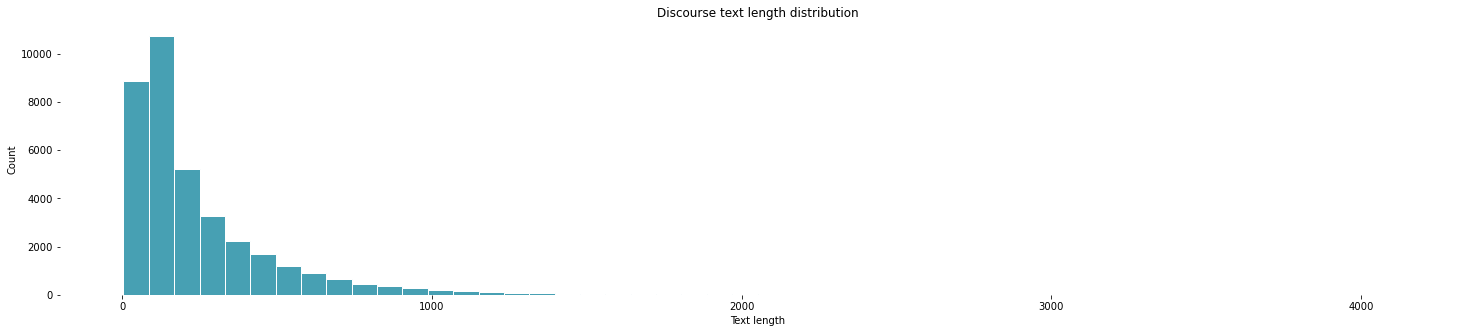

In [ ]:
plt.figure(figsize = (25,5))
plt.hist(subset, bins = 50, edgecolor = 'white')
plt.title('Discourse text length distribution')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.box(False)
plt.show()

In [ ]:
subset = train.discourse_text.str.split(' ').map(len)
subset

0        68
1        42
2        22
3        73
4        19
         ..
36760    22
36761    10
36762    24
36763    82
36764    12
Name: discourse_text, Length: 36765, dtype: int64

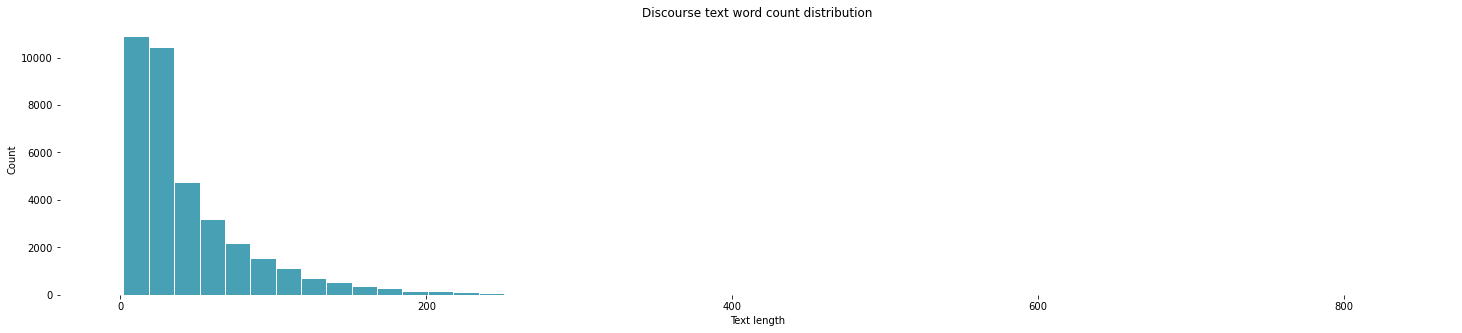

In [ ]:
plt.figure(figsize = (25,5))
plt.hist(subset, bins = 50, edgecolor = 'white')
plt.title('Discourse text word count distribution')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.box(False)
plt.show()

####  Why and how does _discourse type_ matter?

In [ ]:
train[train.loc[:, 'discourse_type'] == 'Lead']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,Limiting the usage of cars has personal and pr...
20,ed7e62a18bad,00BD97EA4041,Should computers read the emotional expression...,Lead,Adequate,Should computers read the emotional expression...
33,ed3a833a2f49,013B9AA6B9DB,What is that thing on Mars?,Lead,Adequate,"What is that thing on Mars?\n\nWell, some peop..."
44,55f4bc9b664b,0158970BC5D2,Students around the world are forgetting more ...,Lead,Adequate,Students around the world are forgetting more ...
...,...,...,...,...,...,...
36699,c42e3ed1626b,FD8A9514C8BC,Not too long ago I got into a disagreement wit...,Lead,Adequate,Not too long ago I got into a disagreement wit...
36708,d934843f1543,FDF0AEEB14C3,Going to school everyday can be difficult for ...,Lead,Effective,Going to school everyday can be difficult for ...
36723,bf5f089e19df,FE3CA06DDCA1,Why is it when someone asks you for advice the...,Lead,Ineffective,Why is it when someone asks you for advice the...
36730,cea348b818a9,FEF42864AE28,"During a long day at school, have you ever tho...",Lead,Effective,"During a long day at school, have you ever tho..."


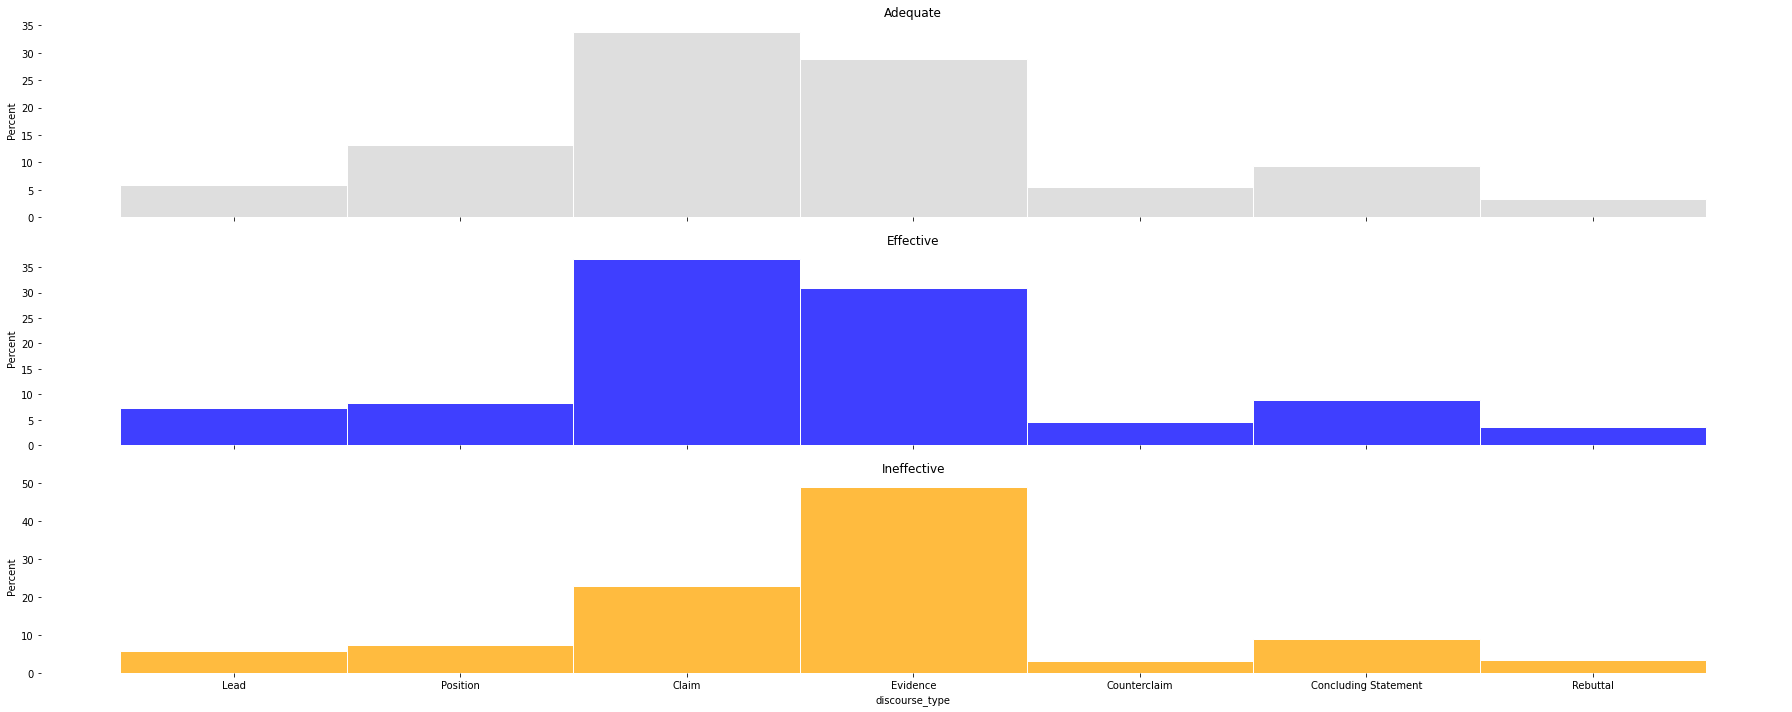

In [ ]:
fig,axs = plt.subplots(nrows = train.discourse_effectiveness.nunique(), ncols = 1,figsize= (25,10), sharex = True)

colors = ['lightgray', 'blue', 'orange']

for idx, eff in enumerate(['Adequate', 'Effective', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].discourse_type, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white', color = colors[idx]).set_title(eff)
    axs[idx].set_frame_on(False)

plt.tight_layout()
plt.show()



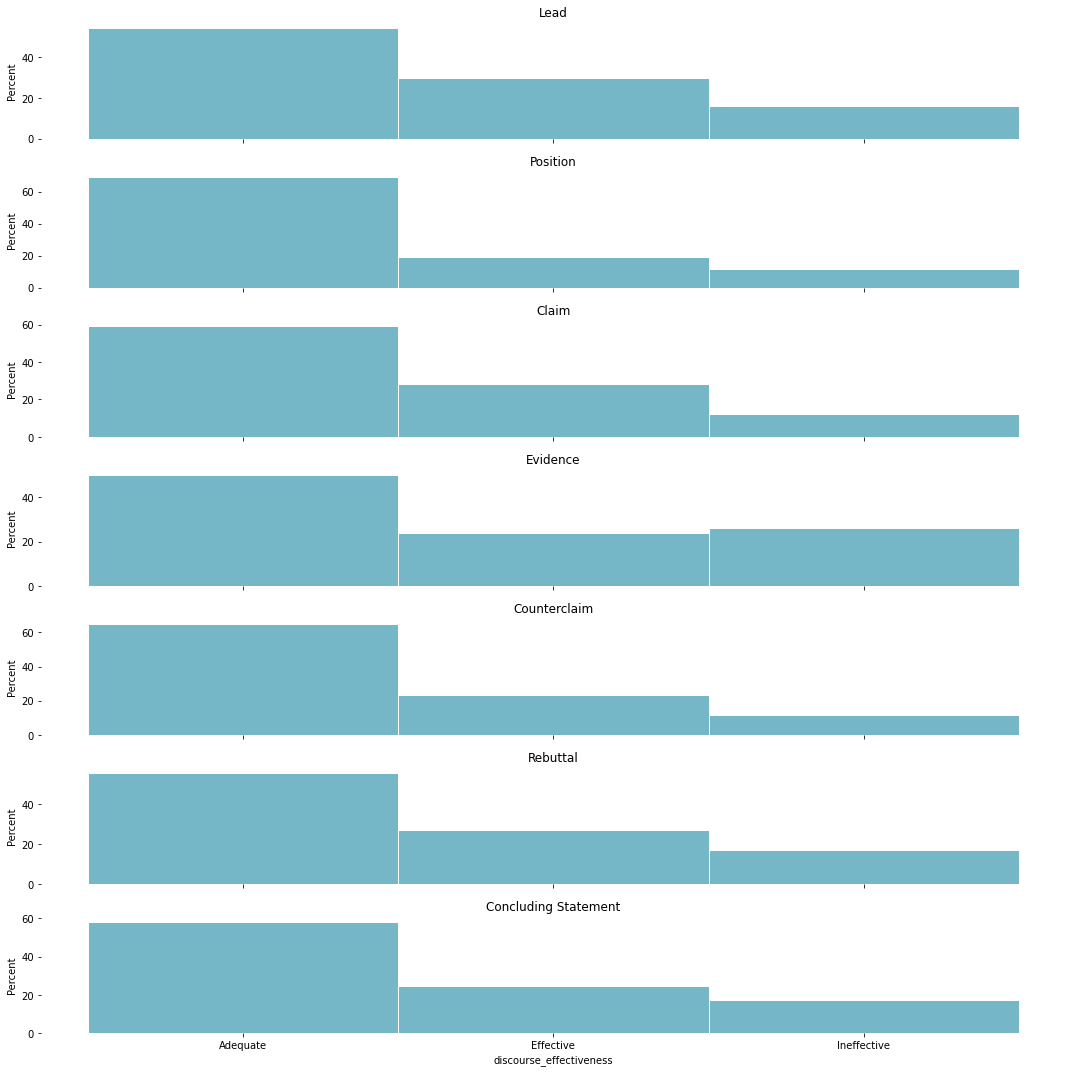

In [ ]:
fig, axs = plt.subplots(nrows = 7, ncols = 1, figsize= (15,15), sharex = True)
for idx, eff in enumerate(train.discourse_type.unique()):
    sns.histplot(train[train.loc[:, 'discourse_type'] == eff].discourse_effectiveness, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.show()

In [ ]:
np.unique(train.groupby('discourse_text').discourse_type.value_counts().values, return_counts=True)

(array([ 1,  2,  3,  4,  5,  7, 14]),
 array([36656,    30,     5,     2,     1,     1,     1]))

In [ ]:
train.discourse_text.nunique()

36691

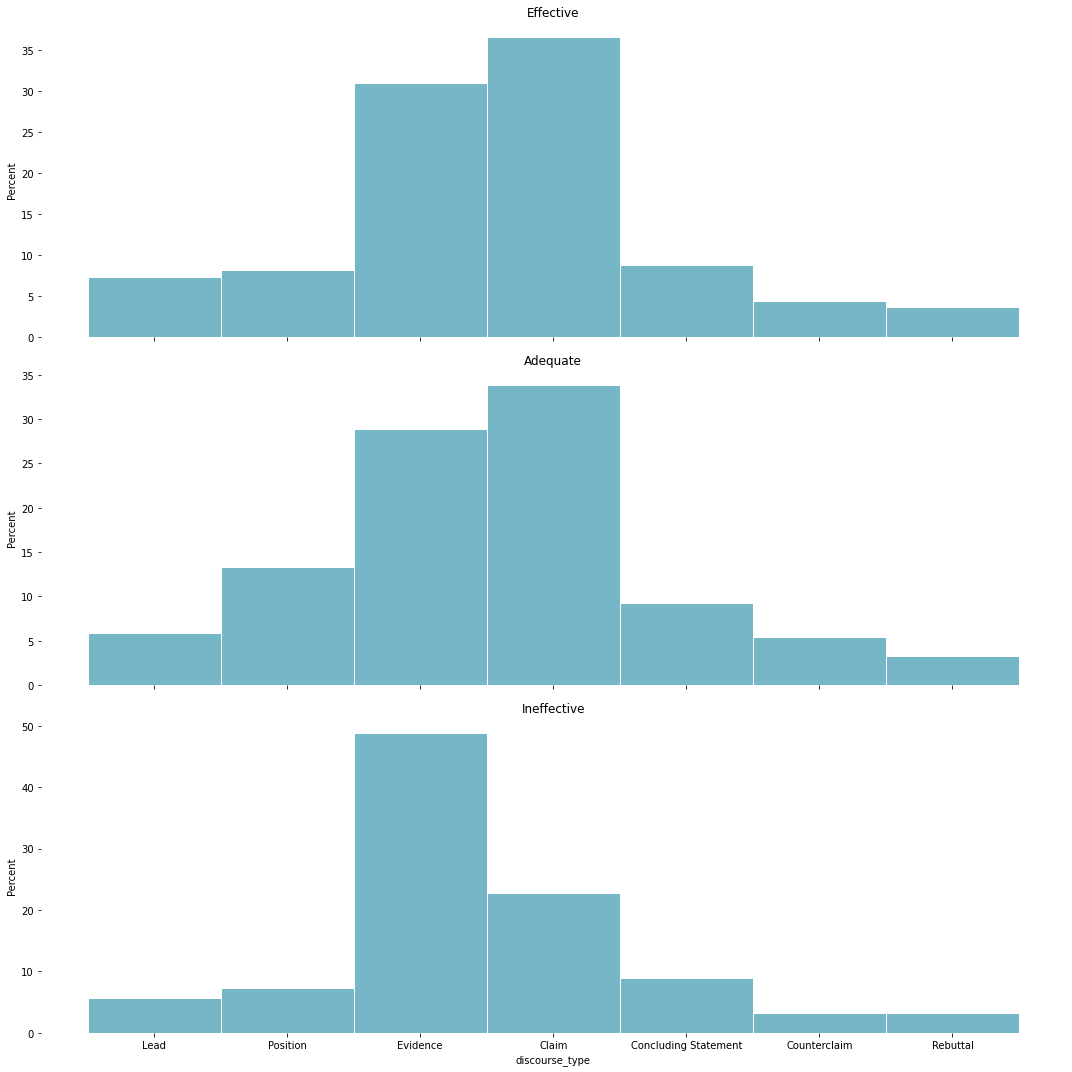

In [ ]:
#### TODO: Needs interpretation

fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (15,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].discourse_type, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.show()



In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import wordcloud as wc
from itertools import chain

In [ ]:
STOPWORDS = set(stopwords.words('english'))

In [ ]:
?wc.WordCloud

Init signature:
wc.WordCloud(
    font_path=None,
    width=400,
    height=200,
    margin=2,
    ranks_only=None,
    prefer_horizontal=0.9,
    mask=None,
    scale=1,
    color_func=None,
    max_words=200,
    min_font_size=4,
    stopwords=None,
    random_state=None,
    background_color='black',
    max_font_size=None,
    font_step=1,
    mode='RGB',
    relative_scaling='auto',
    regexp=None,
    collocations=True,
    colormap=None,
    normalize_plurals=True,
    contour_width=0,
    contour_color='black',
    repeat=False,
    include_numbers=False,
    min_word_length=0,
    collocation_threshold=30,
)
Docstring:     
Word cloud object for generating and drawing.

Parameters
----------
font_path : string
    Font path to the font that will be used (OTF or TTF).
    Defaults to DroidSansMono path on a Linux machine. If you are on
    another OS or don't have this font, you need to adjust this path.

width : int (default=400)
    Width of the canvas.

height : int (defaul

In [ ]:
STOPWORDS.update(['people', 'would','student', 'students', 'school'])

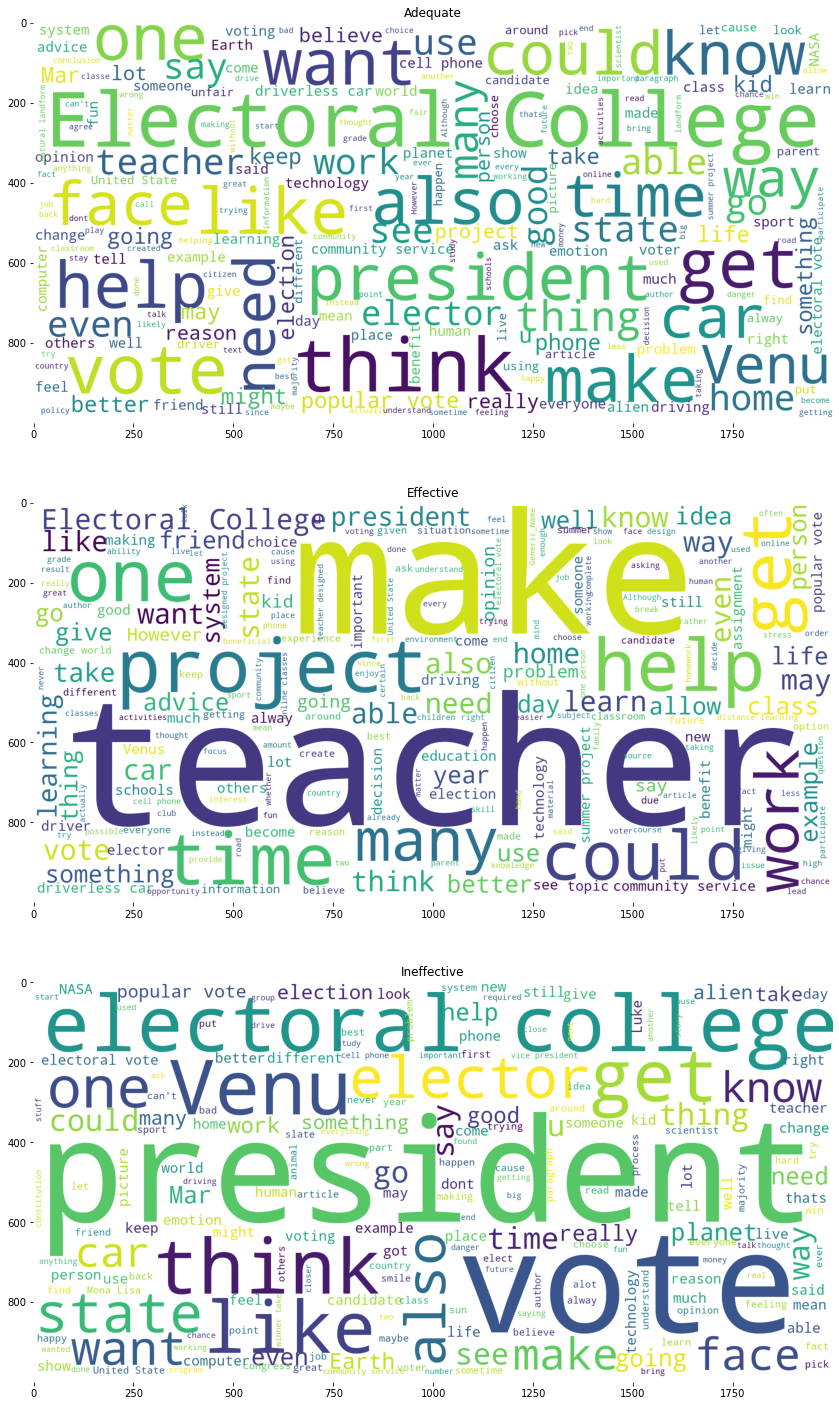

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (25,25))

for idx, label in enumerate(['Adequate', 'Effective', 'Ineffective']):
    subset = train.loc[train['discourse_effectiveness'] == label,:].discourse_text
    subset = ' '.join(subset)
    cloud = wc.WordCloud(background_color = 'white', scale = 5, stopwords=STOPWORDS, max_words=250).generate(subset)
    axs[idx].imshow(cloud)
    axs[idx].set_title(label)
    axs[idx].set_frame_on(False)
    # tokenized_subset = subset.map(word_tokenize)
    # merged_subset = list(chain(*tokenized_subset.to_list()))
    # cloud = wc.WordCloud(token)    


plt.box(False)
plt.show()

One thing that stood out at a first glance is that in the ineffective class named entities have been not capitalized.
Also, it feels like there are more grammar errors. (?)

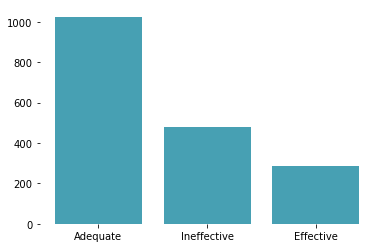

In [ ]:
subset = train.loc[train.discourse_text.str.contains('Venus'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

Ineffective    2
Name: discourse_effectiveness, dtype: int64


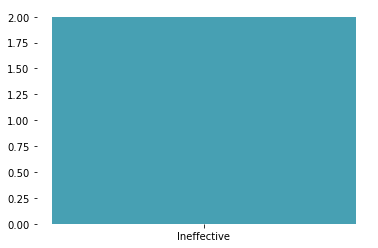

In [ ]:
subset = train.loc[train.discourse_text.str.contains('Venu '),:].discourse_effectiveness.value_counts()
print(subset)
plt.bar(x = subset.index, height = subset.values)
plt.box(False)


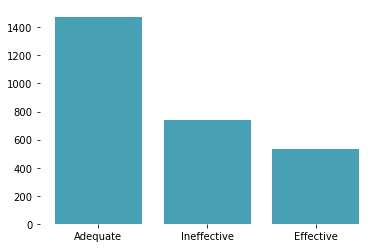

In [ ]:
subset = train.loc[train.discourse_text.str.contains('president'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

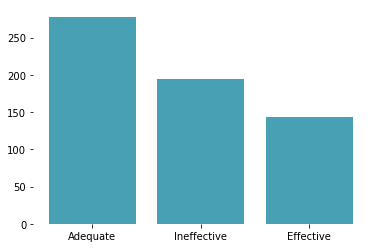

In [ ]:
subset = train.loc[train.discourse_text.str.contains('President'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

In [ ]:
from spylls.hunspell import Dictionary
from string import punctuation
import re
import contractions
DICTIONARY = Dictionary.from_files('en_US')
PUNCTUATIONS = set(list(punctuation))
PUNCTUATIONS.update("`")
PUNCTUATIONS.update("'")

ModuleNotFoundError: No module named 'spylls'

In [ ]:
PUNCTUATIONS

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [ ]:
DICTIONARY

In [ ]:
CONTRACTIONS = contractions.contractions_dict
CONTRACTIONS["It'll"] = "It will"
CONTRACTIONS = {key.capitalize(): value for key, value in CONTRACTIONS.items()}


def check_word(token):
    if DICTIONARY.lookup(token):
        return 1
    else:
        return 0

def replace_contractions(text):

    
    for key, value in CONTRACTIONS.items():
        # Upper-case
        text = text.replace(key, value)
        # Lower-case 
        text = text.replace(key.lower(), value.lower())

    # Remove possesives as well 
    text = text.replace("'s", "")

    # Remove unnecessary whitespaces
    text = re.sub(' +', ' ', text)
    
    return text 

NOT_MISTAKES = ['landform', 'driverless']

def remove_empty_tokens(list_of_tokens):
    list_of_tokens = list(filter(None, list_of_tokens))
    return list_of_tokens

def check_in_dictionary(sentences):

    # If the contraction can be removed, than it means it's correct; consequently, only possibly incorrect words remain

    tokenized_sentences = word_tokenize(sentences)
    correct_tokens = [check_word(token) if (token not in PUNCTUATIONS) and (token not in NOT_MISTAKES)  else 1 for token in tokenized_sentences]

    return correct_tokens

def get_incorrect_indices(correct_word_list):
    return [idx for idx, value in enumerate(correct_word_list) if not value]

def get_incorrect_words(words_list, indices):
    return [words_list[idx] for idx in indices if words_list[idx] ]


In [ ]:
train 

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate,Some people may ask multiple people for advice...
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate,Some people may ask multiple people for advice...
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,Adequate,Some people may ask multiple people for advice...
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective,Some people may ask multiple people for advice...


In [ ]:
train['text_'] = train.discourse_text.map(replace_contractions)

In [ ]:
train['tokenized_sentences'] = train.text_.map(word_tokenize)

In [ ]:
# train['tokenized_sentences'] = train.tokenized_sentences.map(remove_empty_tokens)

In [ ]:
train['correct_list'] = train.text_.map(check_in_dictionary)

In [ ]:
train['incorrect_indices'] = train.correct_list.map(get_incorrect_indices)

In [ ]:
train['incorrect_words'] = train.apply(lambda x: get_incorrect_words(x.tokenized_sentences, x.incorrect_indices), axis = 1)

In [ ]:
train['incorrect_words_len'] = train.incorrect_words.map(len)

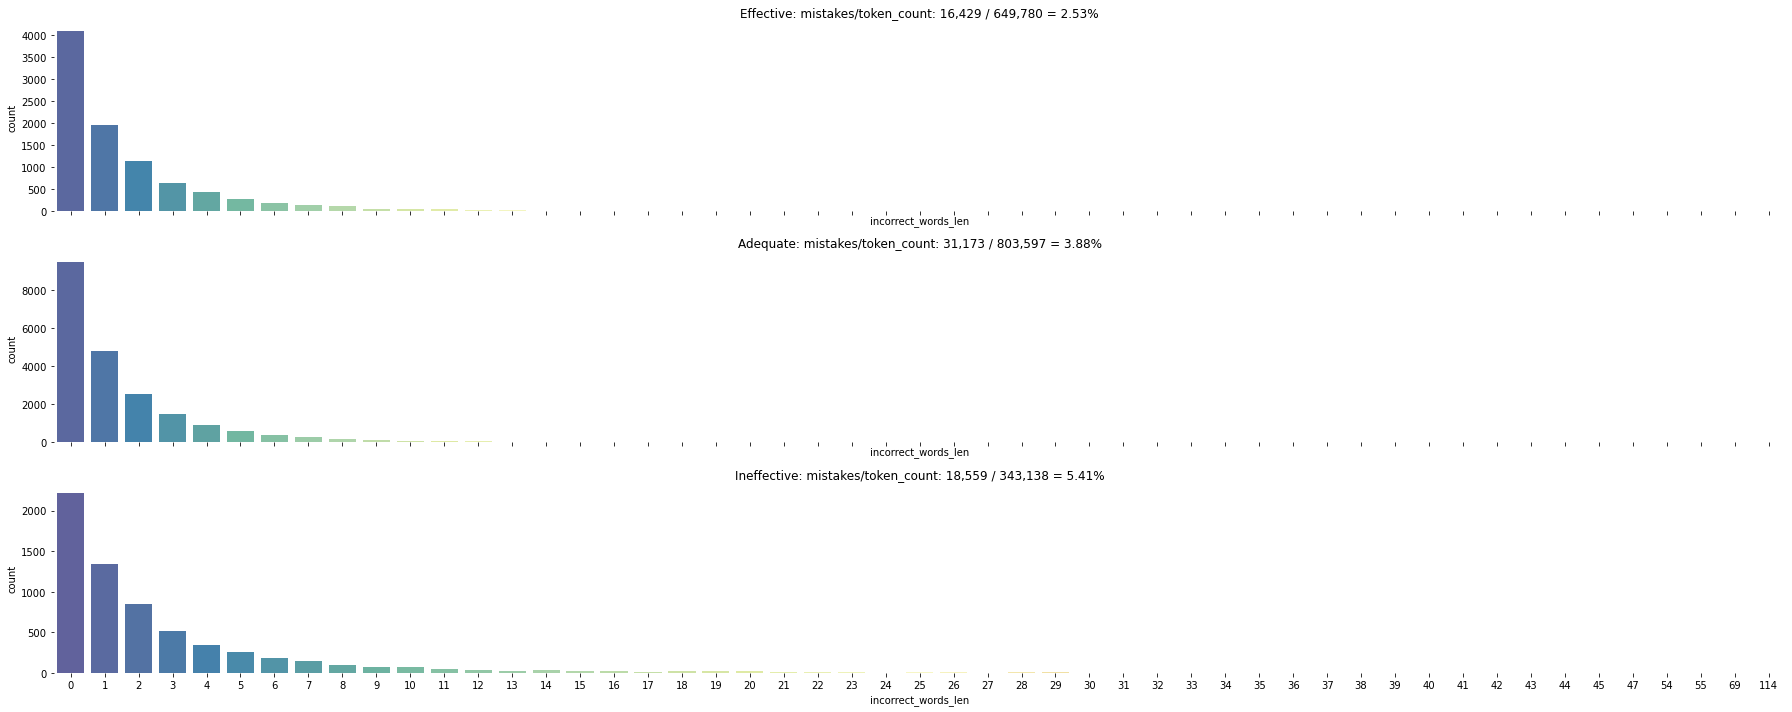

In [ ]:
fig, axs = plt.subplots(nrows = 3 , ncols = 1, figsize= (25,10), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    subset = train.loc[train.discourse_effectiveness == eff].incorrect_words_len
    subset_sum = subset.sum()
    total_token_count = train.loc[train.discourse_effectiveness == eff].tokenized_sentences.map(len).sum()
    sns.countplot(x = subset, ax = axs[idx], palette = 'Spectral_r').set_title(f"{eff}: mistakes/token_count: {subset_sum:,} / {total_token_count:,} = {subset_sum/total_token_count:.2%}") 
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.box(False)
plt.show()


#### WORDCLOUD for flagged mistakes/typos

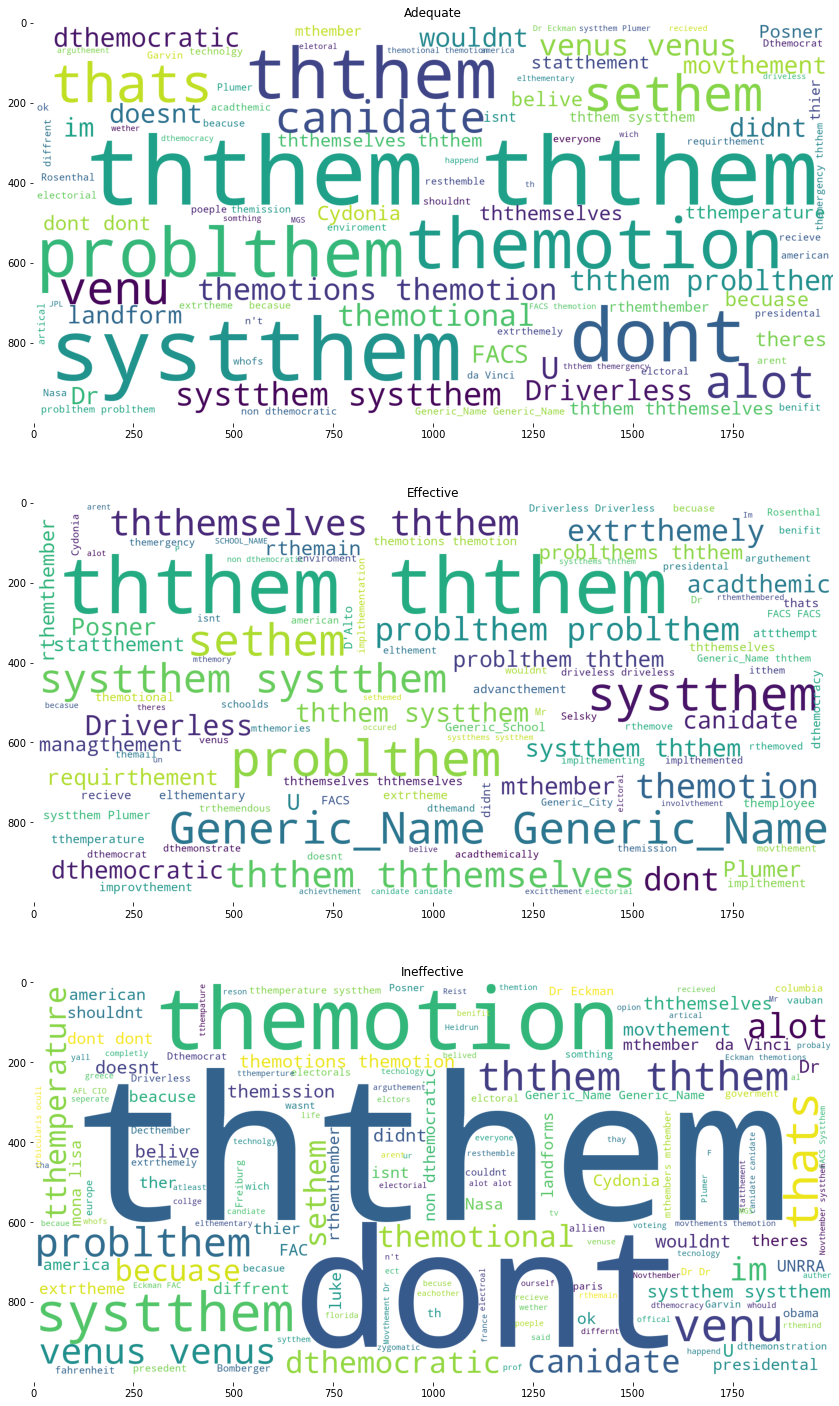

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (25,25))

for idx, label in enumerate(['Adequate', 'Effective', 'Ineffective']):
    subset = train.loc[train['discourse_effectiveness'] == label,:].incorrect_words.map(' '.join)
    subset = ' '.join(subset)
    cloud = wc.WordCloud(background_color = 'white', scale = 5, stopwords=STOPWORDS, max_words=500).generate(subset)
    axs[idx].imshow(cloud)
    axs[idx].set_title(label)
    axs[idx].set_frame_on(False)
    # tokenized_subset = subset.map(word_tokenize)
    # merged_subset = list(chain(*tokenized_subset.to_list()))
    # cloud = wc.WordCloud(token)    


plt.box(False)
plt.show()

#### NER
TODO: Named entity recognition, check if capitalized

#### Relative position of argument in essay

In [ ]:
def find_relative_position(argument, essay):
    essay_length = len(essay)
    split_essay = essay.split(argument.strip())
    
    if split_essay[0] == essay:
        return (0,0)

    if split_essay ==  ['', '']:
        return (0,1)
    
    if split_essay[0] == '':
        return (0, (essay_length - len(split_essay[1])) / essay_length)
    
    try:
        if split_essay[1] == '':  
            return ((essay_length - len(split_essay[0])) / essay_length, 1)
    except:
        return None
    else:
        return (
            len(split_essay[0]) / essay_length,
            (len(split_essay[0]) + len(argument)) / essay_length)

In [ ]:
find_relative_position(argument = 'exmachin', essay = 'deusexmachina')

(0.3076923076923077, 0.9230769230769231)

In [ ]:
"alma".split('alma')

['', '']

In [ ]:
from unidecode import unidecode

In [ ]:
unidecode(train.essay_text.iloc[0])

'Hi, i\'m Isaac, i\'m going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn\'t know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I\'ll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It\'s not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at this point. In all that they\'re saying, its probably a natural landf

In [ ]:
train.essay_text.iloc[0]

'Hi, i\'m Isaac, i\'m going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn\'t know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I\'ll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It\'s not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at this point. In all that they\'re saying, its probably a natural landf

In [ ]:
train['relative_position'] = train.apply(lambda x: find_relative_position(argument = x.discourse_text, essay = x.essay_text), axis = 1)

In [ ]:
subset_of_interest = train.loc[train.relative_position.isna()]
subset_of_interest

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,text_,tokenized_sentences,correct_list,incorrect_indices,incorrect_words,incorrect_words_len,relative_position


In [ ]:
subset_of_interest.discourse_text

Series([], Name: discourse_text, dtype: object)

In [ ]:
subset_of_interest.essay_text

Series([], Name: essay_text, dtype: object)

#### SLANG

#### Common english words

#### Syllables

In [ ]:
from hyphenate import hyphenate_word
from nltk.tokenize import sent_tokenize

In [ ]:
train['sentences'] = train.discourse_text.map(sent_tokenize)
train['words'] = train.sentences.apply(lambda sentences: list(chain(*[word_tokenize(sentence) for sentence in sentences])))
train['words'] = train.words.apply(lambda tokens: [token for token in tokens if (token not in PUNCTUATIONS and token != '')])
train['syllables'] = train.words.apply(lambda tokens: list(chain(*[hyphenate_word(token) for token in tokens])))

In [ ]:
train['sent_count'] = train.sentences.map(len)
train['word_count'] = train.words.map(len)
train['syll_count'] = train.syllables.map(len)

train['words_per_sentences'] = train['sent_count'] / train['word_count']
train['syll_per_sentences'] =  train['sent_count'] / train['syll_count'] 
train['syll_per_words'] = train['word_count'] / train['syll_count']

In [ ]:
train

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,text_,tokenized_sentences,correct_list,incorrect_indices,...,relative_position,sentences,words,syllables,sent_count,word_count,syll_count,words_per_sentences,syll_per_sentences,syll_per_words
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","Hi, i am Isaac, i am going to be writing about...","[Hi, ,, i, am, Isaac, ,, i, am, going, to, be,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],...,"(0, 0.17400881057268722)","[Hi, i'm Isaac, i'm going to be writing about ...","[Hi, i, 'm, Isaac, i, 'm, going, to, be, writi...","[Hi, i, 'm, Isaac, i, 'm, go, ing, to, be, wri...",3,70,84,0.042857,0.035714,0.833333
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","On my perspective, I think that the face is a ...","[On, my, perspective, ,, I, think, that, the, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[15],...,"(0.17455947136563876, 0.29019823788546256)","[On my perspective, I think that the face is a...","[On, my, perspective, I, think, that, the, fac...","[On, my, per, spec, tive, I, think, that, the,...",2,42,53,0.047619,0.037736,0.792453
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...",I think that the face is a natural landform be...,"[I, think, that, the, face, is, a, natural, la...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[19],...,"(0.2907488986784141, 0.348568281938326)",[I think that the face is a natural landform b...,"[I, think, that, the, face, is, a, natural, la...","[I, think, that, the, face, is, a, nat, ur, al...",1,21,27,0.047619,0.037037,0.777778
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","If life was on Mars, we would know by now. The...","[If, life, was, on, Mars, ,, we, would, know, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[41, 48, 50]",...,"(0.3491189427312775, 0.5484581497797357)","[If life was on Mars, we would know by now., T...","[If, life, was, on, Mars, we, would, know, by,...","[If, life, was, on, Mars, we, would, know, by,...",4,76,99,0.052632,0.040404,0.767677
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...",People thought that the face was formed by ali...,"[People, thought, that, the, face, was, formed...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",[8],...,"(0.5490088105726872, 0.6046255506607929)",[People thought that the face was formed by al...,"[People, thought, that, the, face, was, formed...","[Peo, ple, thought, that, the, face, was, form...",1,18,20,0.055556,0.050000,0.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate,Some people may ask multiple people for advice...,For many people they do not like only asking o...,"[For, many, people, they, do, not, like, only,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],...,"(0.08082901554404145, 0.21139896373056996)",[For many people they don't like only asking o...,"[For, many, people, they, do, n't, like, only,...","[For, many, peo, ple, they, do, n't, like, onl...",1,22,31,0.045455,0.032258,0.709677
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate,Some people may ask multiple people for advice...,also people have different views and opinions ...,"[also, people, have, different, views, and, op...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",[],...,"(0.21243523316062177, 0.27150259067357513)",[also people have different views 

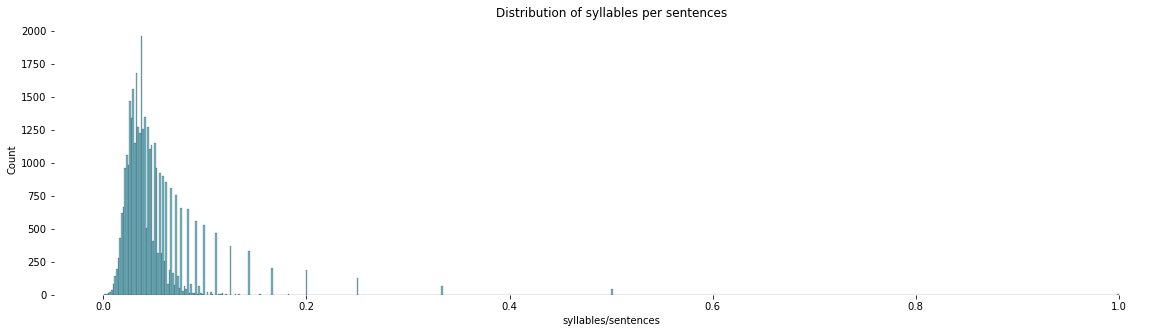

In [ ]:
fig = plt.figure(figsize = (20,5))
sns.histplot(train.syll_per_sentences)
plt.title('Distribution of syllables per sentences')
plt.xlabel('syllables/sentences')
plt.ylabel('Count')
plt.box(False)
plt.show()

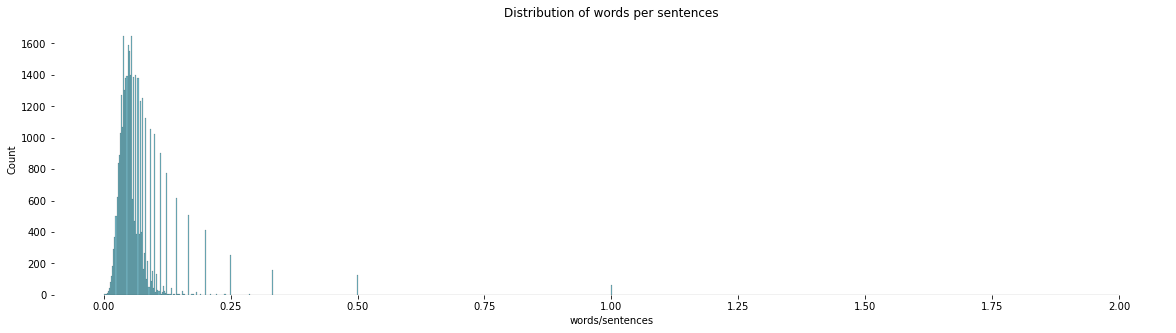

In [ ]:
fig = plt.figure(figsize = (20,5))
sns.histplot(train.words_per_sentences)
plt.title('Distribution of words per sentences')
plt.xlabel('words/sentences')
plt.ylabel('Count')
plt.box(False)
plt.show()

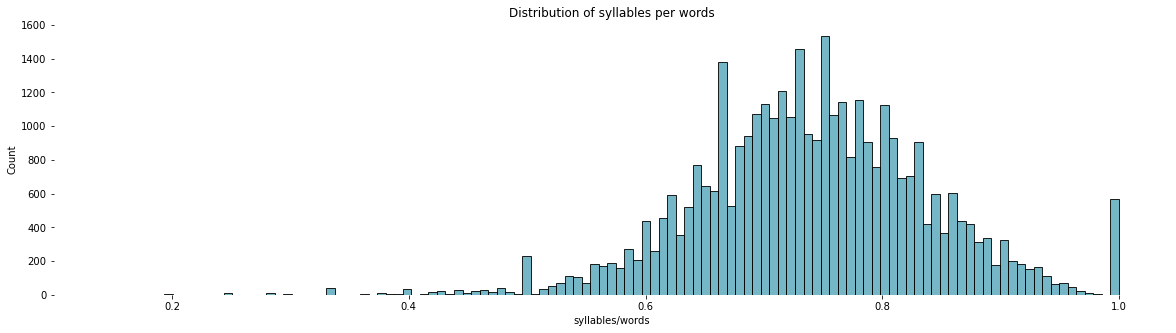

In [ ]:
fig = plt.figure(figsize = (20,5))
sns.histplot(train.syll_per_words)
plt.title('Distribution of syllables per words')
plt.xlabel('syllables/words')
plt.ylabel('Count')
plt.box(False)
plt.show()

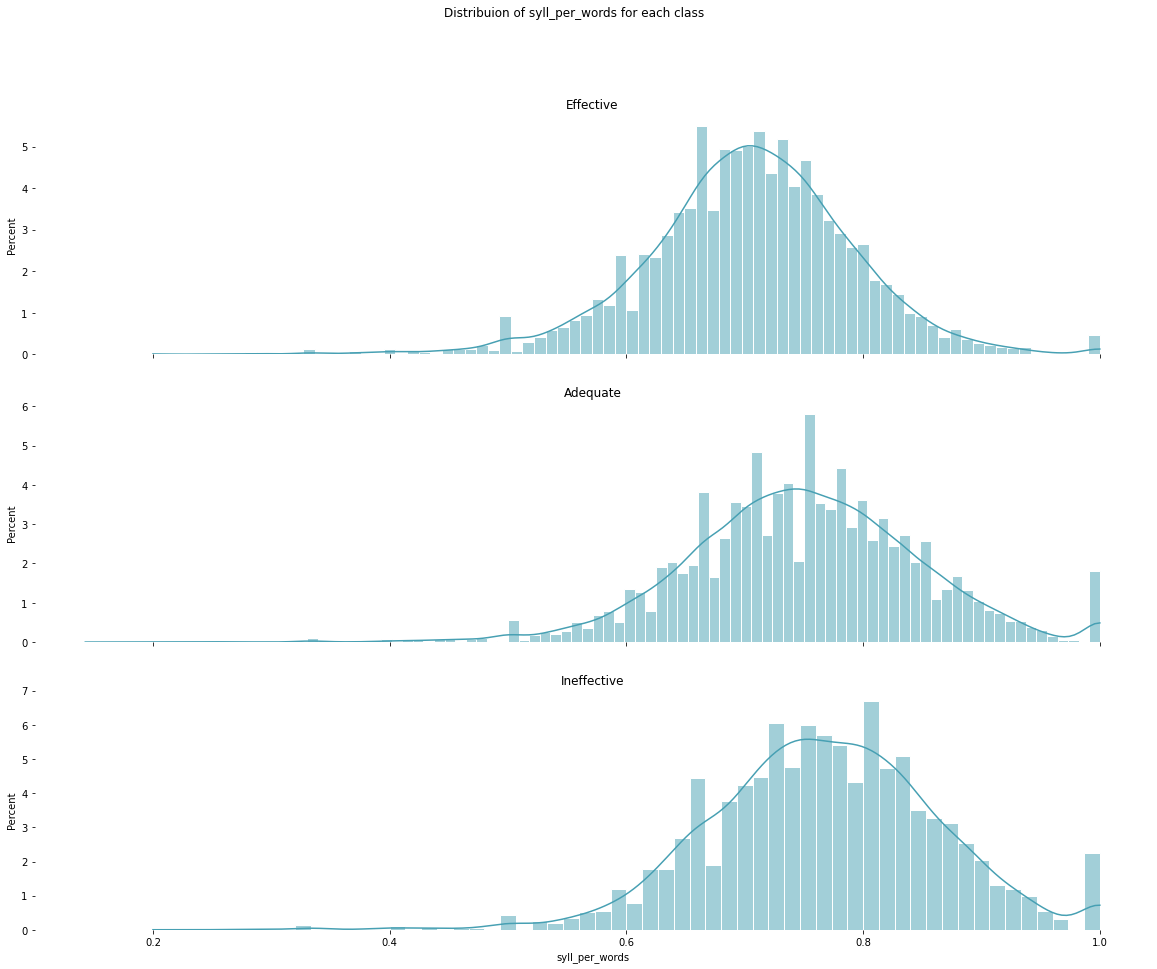

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (20,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].syll_per_words, ax = axs[idx], stat = 'percent', kde=True, label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.suptitle('Distribuion of syll_per_words for each class')
plt.show()

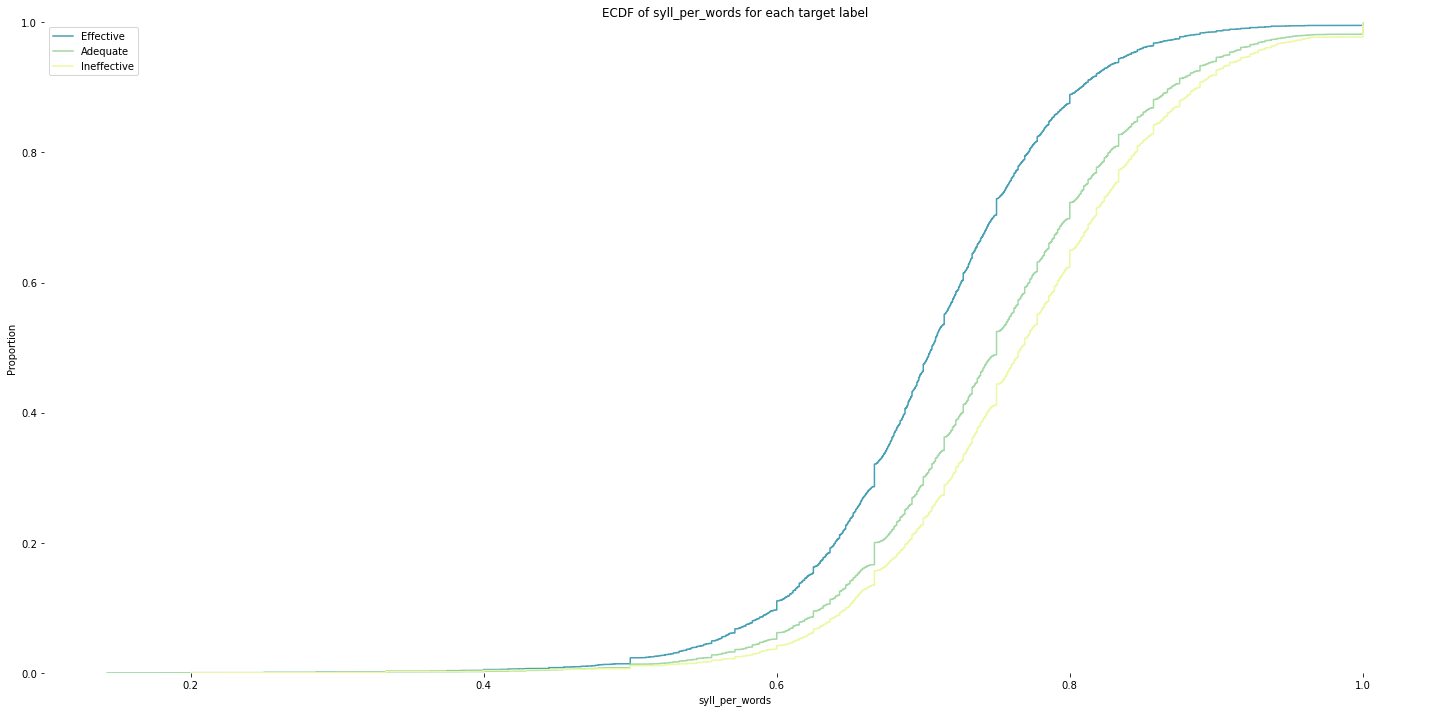

In [ ]:
fig = plt.figure(figsize= (20,10))

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.ecdfplot(train[train.loc[:, 'discourse_effectiveness'] == eff].syll_per_words, label = eff).set_title(eff)
plt.box(False)
plt.legend()
plt.title("ECDF of syll_per_words for each target label")
plt.tight_layout()
plt.show()

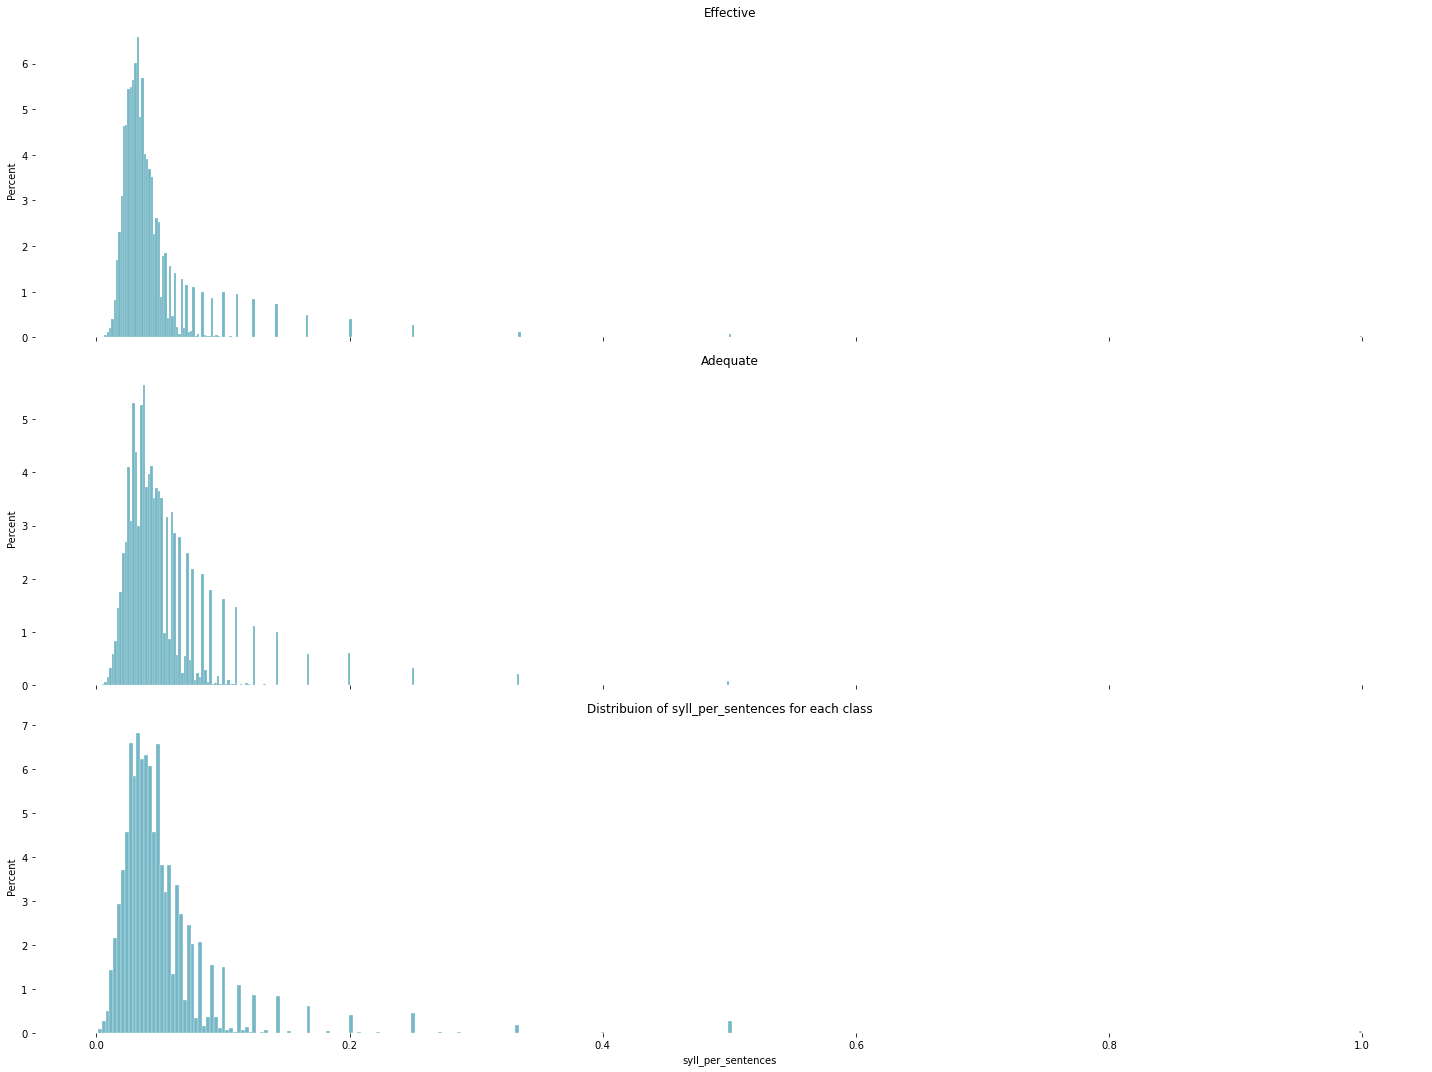

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (20,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].syll_per_sentences, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.title('Distribuion of syll_per_sentences for each class')
plt.show()

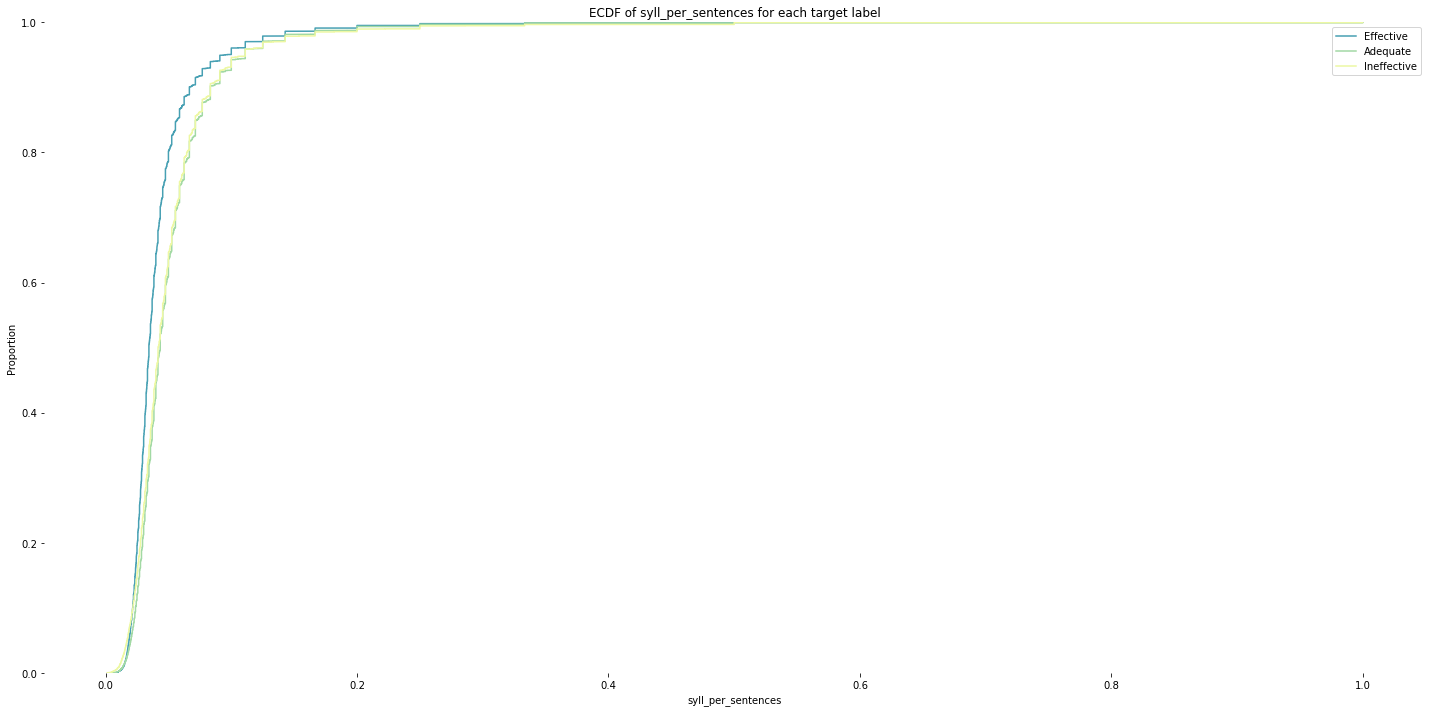

In [ ]:
fig = plt.figure(figsize= (20,10))

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.ecdfplot(train[train.loc[:, 'discourse_effectiveness'] == eff].syll_per_sentences, label = eff).set_title(eff)
plt.box(False)
plt.legend()
plt.title("ECDF of syll_per_sentences for each target label")
plt.tight_layout()
plt.show()

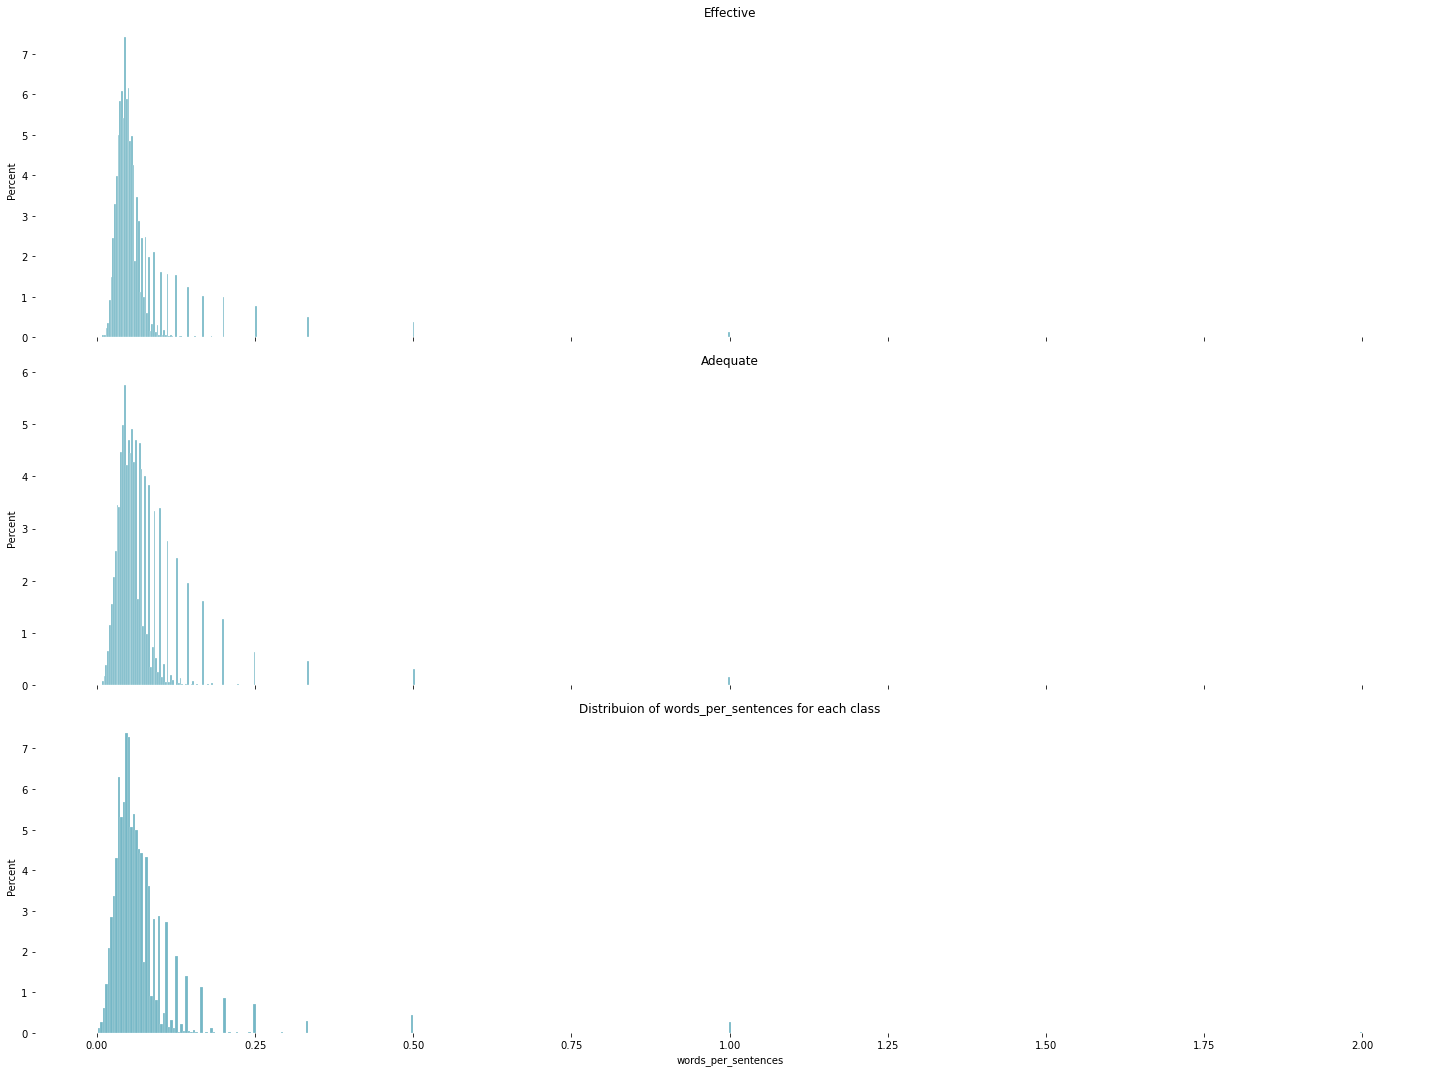

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (20,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].words_per_sentences, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.title('Distribuion of words_per_sentences for each class')
plt.show()

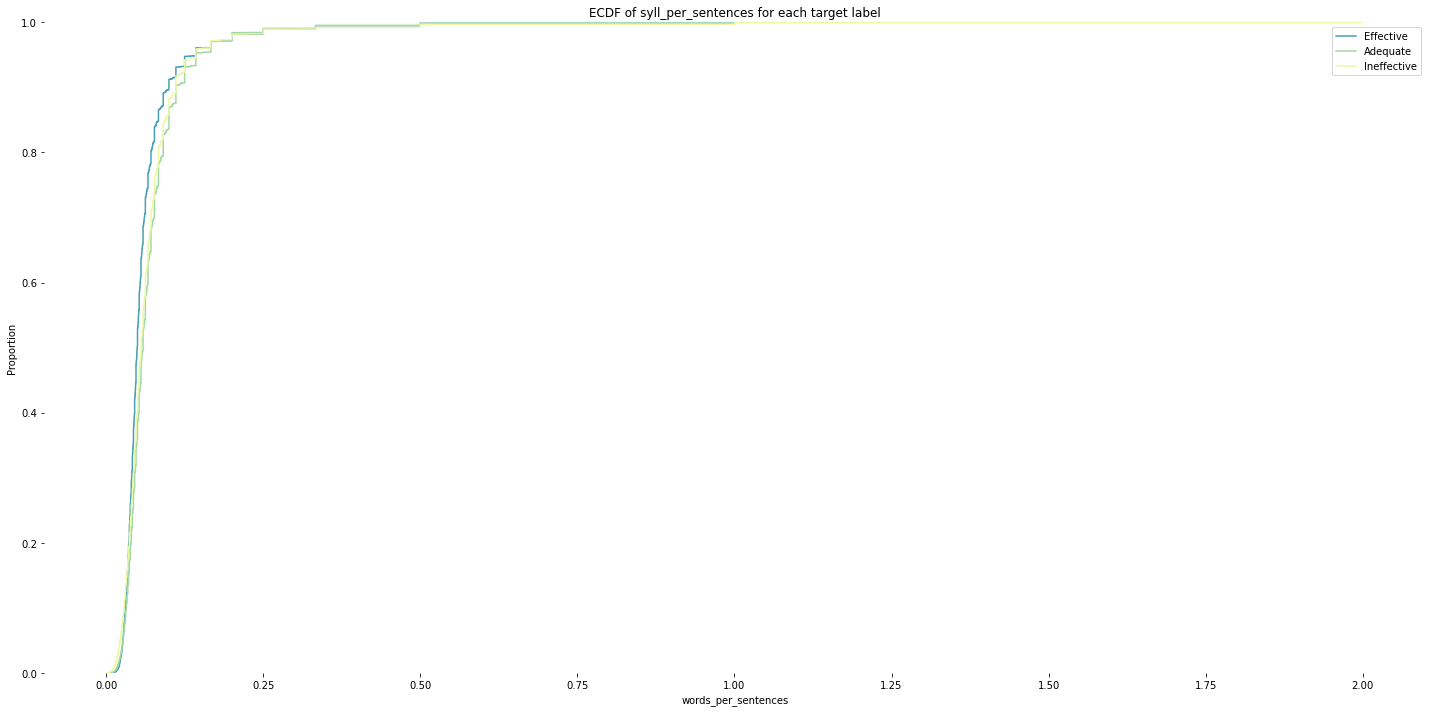

In [ ]:
fig = plt.figure(figsize= (20,10))

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.ecdfplot(train[train.loc[:, 'discourse_effectiveness'] == eff].words_per_sentences, label = eff).set_title(eff)
plt.box(False)
plt.legend()
plt.title("ECDF of syll_per_sentences for each target label")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from category_encoders import OneHotEncoder
from scipy import sparse
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, confusion_matrix

In [107]:
target_labels_mapping = {"Ineffective": 0, "Adequate":1, "Effective":2}
reversed_target_label = {str(value): key for key, value, in target_labels_mapping.items()}
train.discourse_effectiveness = train.discourse_effectiveness.map(target_labels_mapping)
X, Y = train.drop('discourse_effectiveness', axis=1, inplace = False), train.discourse_effectiveness
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state=RANDOM_SEED, stratify=train.discourse_effectiveness)

In [108]:
x_train = X_train
y_train = Y_train.to_numpy()

x_valid = X_test
y_valid = Y_test.to_numpy()

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train.essay_text.drop_duplicates())

vectorized_discourse_text_train = vectorizer.transform(x_train.discourse_text)
vectorized_discourse_text_test = vectorizer.transform(x_valid.discourse_text)

ohe = OneHotEncoder()
ohe_discourse_type_train = ohe.fit_transform(x_train.discourse_type.values.reshape(-1, 1))
ohe_discourse_type_test = ohe.transform(x_valid.discourse_type.values.reshape(-1, 1))

x_train = sparse.hstack([vectorized_discourse_text_train, ohe_discourse_type_train])
x_valid = sparse.hstack([vectorized_discourse_text_test, ohe_discourse_type_test])

# In case it is necessary
# scaler = MaxAbsScaler()
# x_train = scaler.fit_transform(x_train)
# x_valid = scaler.transform(x_valid)

model = XGBClassifier()
model.fit(x_train, y_train)
actual_pred = model.predict(x_valid)
prob_predictions = model.predict_proba(x_valid)
lloss = log_loss(y_valid, prob_predictions)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:00:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	Log loss: 0.7671707691490502
	Accuracy: 0.65687474500204
................................................................................


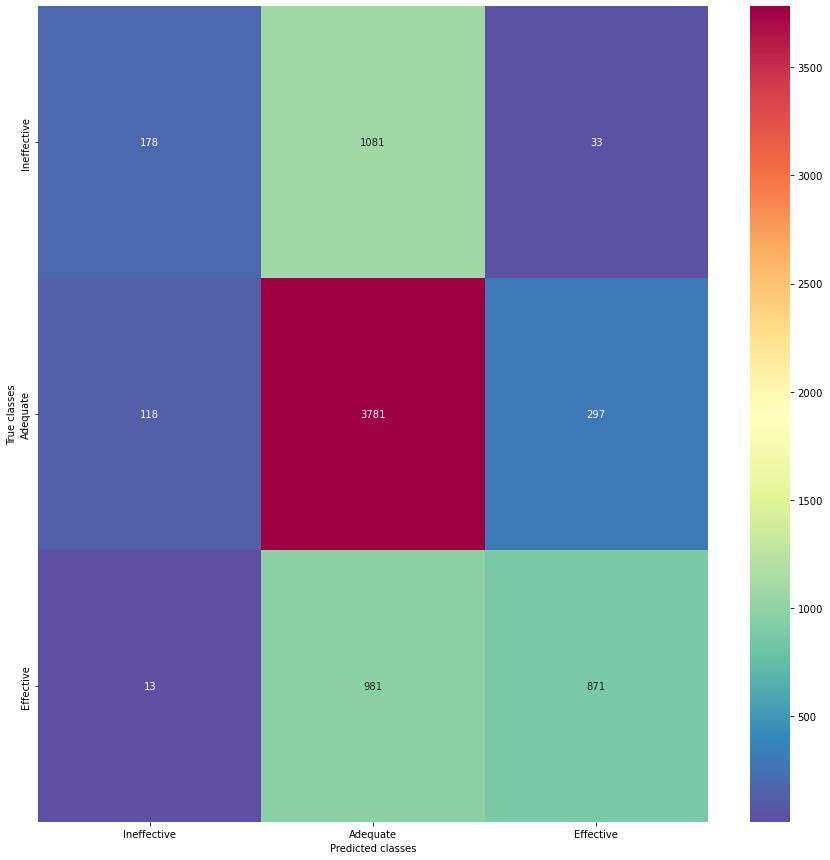

In [109]:

cfm = confusion_matrix(y_true = y_valid, y_pred = actual_pred)

plt.figure(figsize=(15,15))
sns.heatmap(cfm, annot = True, fmt = '.0f', cmap = 'Spectral_r', xticklabels=target_labels_mapping.keys(), yticklabels=target_labels_mapping.keys())
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks()

print(f"\tLog loss: {lloss}")
print(f"\tAccuracy: {accuracy_score(y_valid, actual_pred)}")
print(80*'.')

	Log loss: 0.7671707691490502
	Accuracy: 0.65687474500204
................................................................................


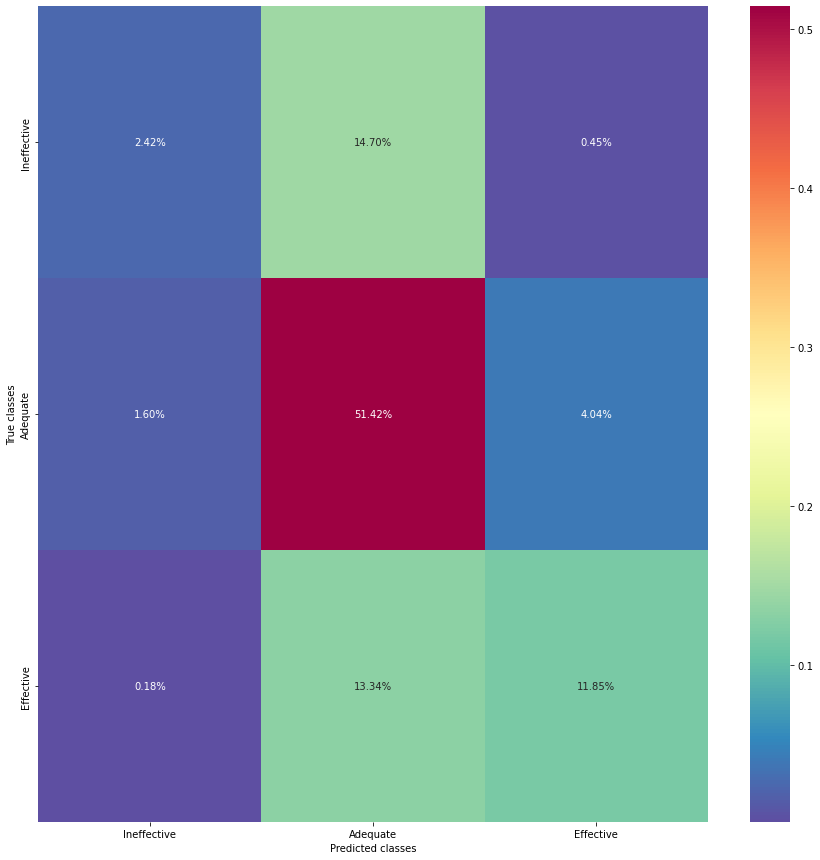

In [110]:

cfm = confusion_matrix(y_true = y_valid, y_pred = actual_pred) / len(y_valid)

plt.figure(figsize=(15,15))
sns.heatmap(cfm, annot = True, fmt = '.2%', cmap = 'Spectral_r', xticklabels=target_labels_mapping.keys(), yticklabels=target_labels_mapping.keys())
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks()

print(f"\tLog loss: {lloss}")
print(f"\tAccuracy: {accuracy_score(y_valid, actual_pred)}")
print(80*'.')

In [111]:
predictions = pd.DataFrame(
    {
        'true_labels' : y_valid, 
        'predicted_labels': actual_pred
    }
)

In [121]:
good_predictions = predictions.loc[predictions.true_labels == predictions.predicted_labels].index
good_predictions

Int64Index([   0,    1,    3,    4,    7,    8,    9,   10,   11,   13,
            ...
            7339, 7340, 7344, 7346, 7347, 7348, 7349, 7350, 7351, 7352],
           dtype='int64', length=4830)

In [126]:
print(f"\n\n Good predictions: ")
for row_idx, prediction in X_test.iloc[good_predictions].sample(10).iterrows():
    
    print()
    print(f"\t{reversed_target_label[str(Y.iloc[row_idx])]}")
    print(f"\t{prediction.discourse_text}")


    print(f"\t{80*'-'}")
    print()




 Good predictions: 

	Adequate
	make someone trust in you to tell their secret to you. 
	--------------------------------------------------------------------------------


	Adequate
	To began, Taking Online class at home is help to take students time. 
	--------------------------------------------------------------------------------


	Ineffective
	The only reason why we build cars and buses and trains and etc is to make us get to things like a if your running late for something and you need to get there really fast you could take your car and get there as fast as you can so your not offically late and not get fired and have to lose your job cause you were late for work.

That's why we have cars to rely on and not our feet the whole time but most times if we dont want to use our car we can always walk there thats somewhere close and not far to walk like the gas station or the park or anything or if your just to dang "LAZY" to even walk that far then you would use a car or if you dont

In [115]:
ineffective_insteadof_adequate = predictions.loc[(predictions.true_labels == 0) & (predictions.predicted_labels == 1)]
ineffective_insteadof_adequate

,true_labels,predicted_labels
14,0,1
19,0,1
21,0,1
22,0,1
42,0,1
...,...,...
7333,0,1
7337,0,1
7341,0,1
7343,0,1


In [116]:
print(f"\n\n Predicted 'Adequate', \n True label 'Ineffective' ")
print(f" Count {len(X_test.iloc[ineffective_insteadof_adequate.index])}")
for row_idx, prediction in X_test.iloc[ineffective_insteadof_adequate.index].sample(25).iterrows():
    
    print()
    print(f"\t{prediction.discourse_text}")


    print(f"\t{80*'-'}")
    print()



 Predicted 'Adequate', 
 True label 'Ineffective' 
 Count 1081

	Under the electoral college system voters not for the president, but for a slate of electors, who in turn elect the president. The electors can be anyone not holding public office. the pickers of first place depends on the state, maybe even state conventions, all these things can help inprove the voting polls and make them quicker    
--------------------------------------------------------------------------------


	That's why it isnt a good idea to be making driverless cars. 
--------------------------------------------------------------------------------


	Taking aways the electoral college is like playing a game that have no obsticles nor opponents to challege you 
--------------------------------------------------------------------------------


	It helps people with an education of like law schools and stuff like that. It helps people in the long run so they no more about the president and the history. 
---------

In [117]:
adequate_insteadof_effective = predictions.loc[(predictions.true_labels == 2) & (predictions.predicted_labels == 1)]
adequate_insteadof_effective

,true_labels,predicted_labels
2,2,1
12,2,1
15,2,1
24,2,1
44,2,1
...,...,...
7314,2,1
7329,2,1
7330,2,1
7335,2,1


In [130]:
print(f"\n\n Predicted 'Adequate', \n True label 'Effective': ")
print(f" Count {len(X_test.iloc[adequate_insteadof_effective.index])}")

for row_idx, prediction in X_test.iloc[adequate_insteadof_effective.index].sample(25).iterrows():
    
    print()
    print(f"\t{prediction.discourse_text}")


    print(f"\t{80*'-'}")
    print()



 Predicted 'Adequate', 
 True label 'Effective': 
 Count 981

	Next, community service will help with your education, because kids who do community service are more likely to get into a good college. 
	--------------------------------------------------------------------------------


	This reason is because of their winner takes all system in each state, candidates don't spend time in the states they feel they have no chance of winning. They only focus on the

"swing" states , the states they feel they have a chance in or feel they have to win over. During the 2000 campaign , seventeen states didn't see the candidates at all and the largest media didn't get to see a single  campaign ad. Candidates only visit states they feel are important to them which is considered unfair to the voters who actually vote for them. 
	--------------------------------------------------------------------------------


	This sums up that the process is unfair to many of the states voters and must be chang

In [119]:
X.loc[X.discourse_text.str.contains('so I')]

,discourse_id,essay_id,discourse_text,discourse_type,essay_text
590,0b5aba2c95e3,0C8E8861F91A,"In a whole, this is a lot to disagree with, si...",Concluding Statement,I agree with the claim against the value of us...
840,8cab1a20ad9d,1006FE578078,Students graduating shouldn't be decided by if...,Concluding Statement,Making extracurricular activities mandatory fo...
1738,22710b811e88,2017D32A0639,The point of a summer assignment is to prevent...,Evidence,Many schools across the country require studen...
2488,d7da98659b61,2D644290FFF5,venus is also named after a strip club but any...,Evidence,Studying venus is wrothy pursuit despite the d...
2560,a02f0bf9fce1,2E57A0350FFD,I love being able to go out on the sea and hav...,Evidence,Being a seagoing cowboy was much more than adv...
...,...,...,...,...,...
36336,b1c407e493d2,E0B1630FB93C,By gaining a different viewpoint of the decisi...,Evidence,Gathering multiple opinions helps people make ...
36338,23349ff835db,E0B1630FB93C,"If you ask someone for advice, they may be abl...",Evidence,Gathering multiple opinions helps people make ...
36404,ccd88a2d496e,E53B5654C0E2,For example my cousin Generic_Name was acting ...,Evidence,I believe talking to more then one person is t...
36499,238f666aa315,EBBA36F7459C,"For example, if someone talked to just their g...",Evidence,The Importance of Multiple Opinions\n\nGeneric...


#### POS

In [131]:
import spacy
# spacy.load('en_core_web_lg')

2022-08-18 03:20:27.580663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 03:20:27.614329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-18 03:20:27.614342: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
